In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Files
path='/content/drive/MyDrive/brain-tumor-dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,meningioma_tumor
1,normal
2,glioma_tumor
3,pituitary_tumor


In [ ]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 3096 files belonging to 4 classes.
Using 2477 files for training.
Found 3096 files belonging to 4 classes.
Using 619 files for validation.


In [ ]:
class_names = train.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

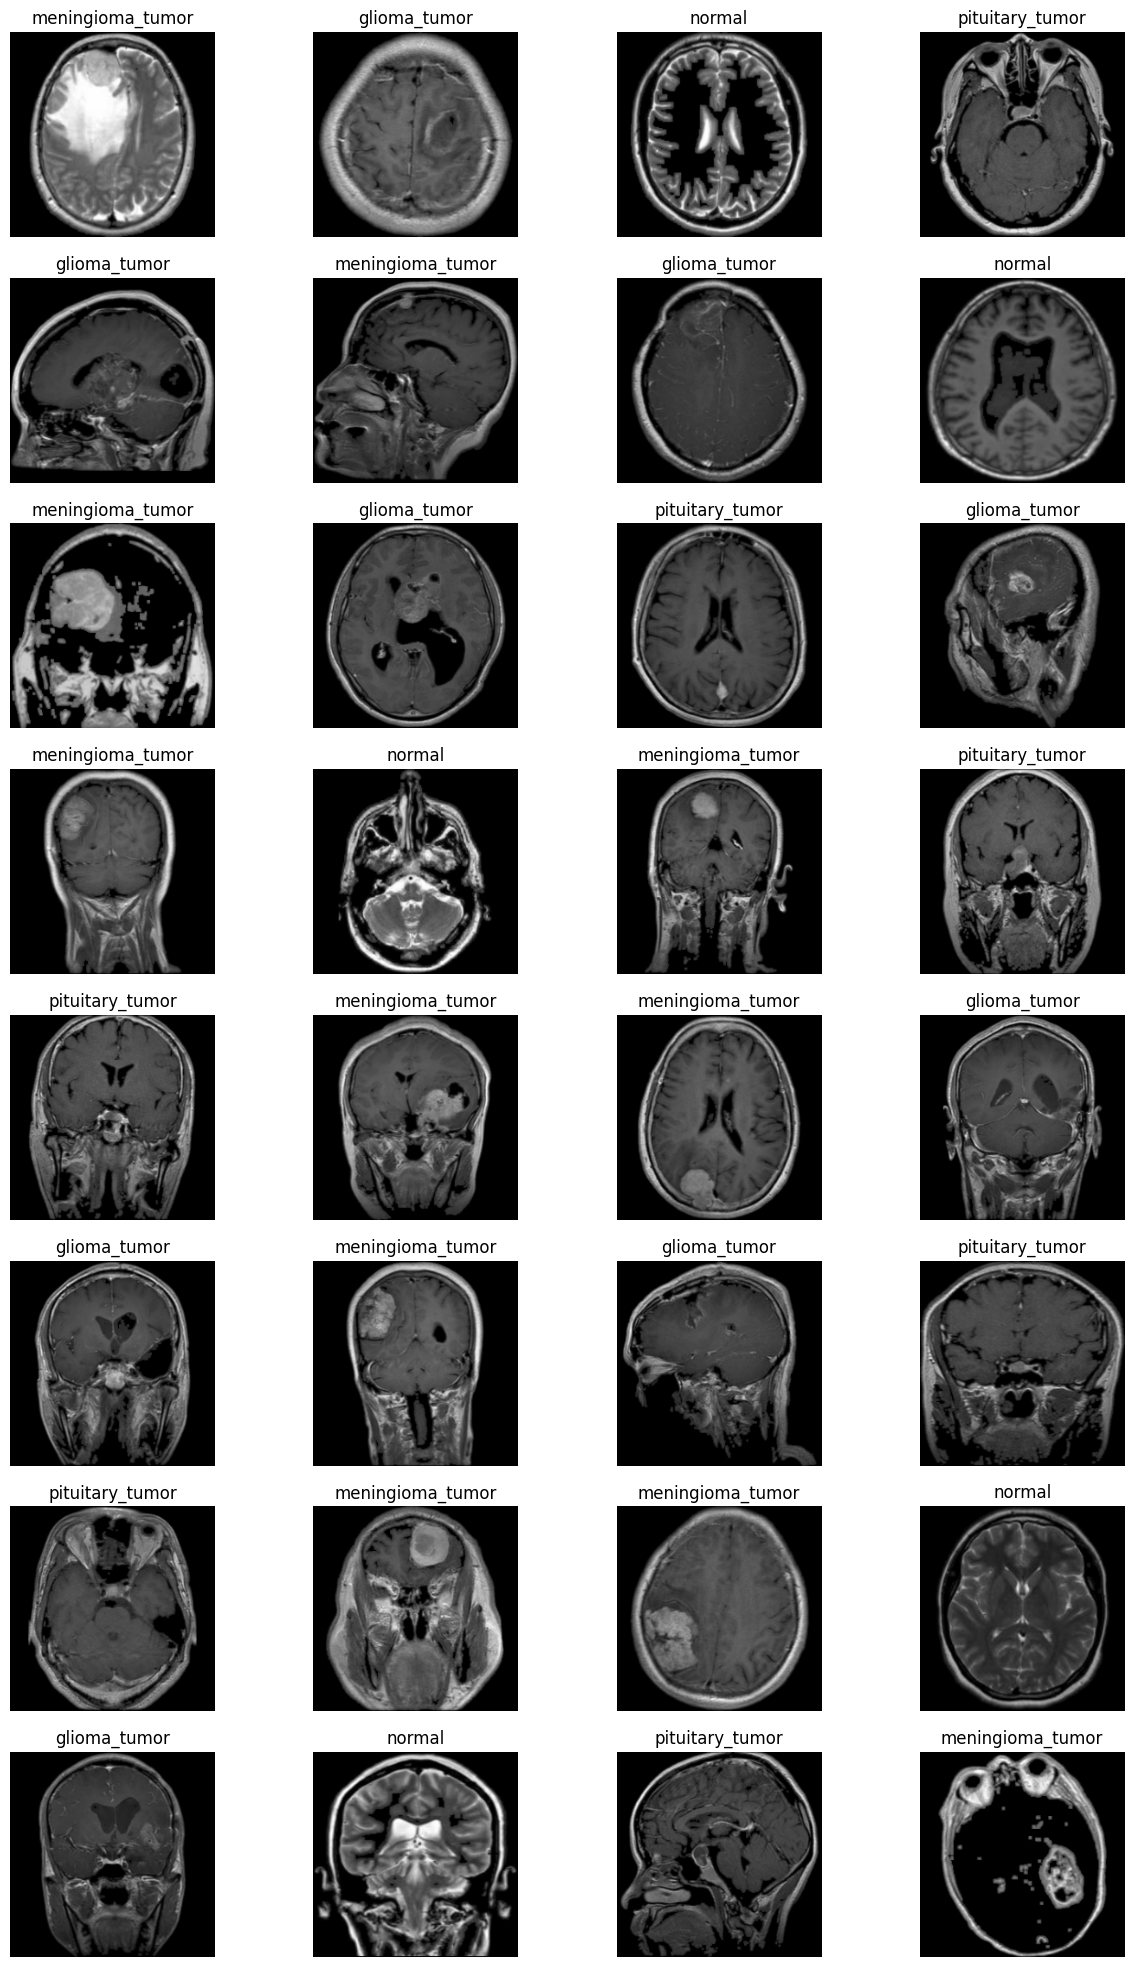

In [ ]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
base_model = None
model = None
with tf.device('/device:GPU:0'):
  base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
  base_model.trainable = False
  model=keras.models.Sequential()
  model.add(base_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(.5))
  model.add(keras.layers.Dense(4,activation=tf.nn.softmax))
  model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


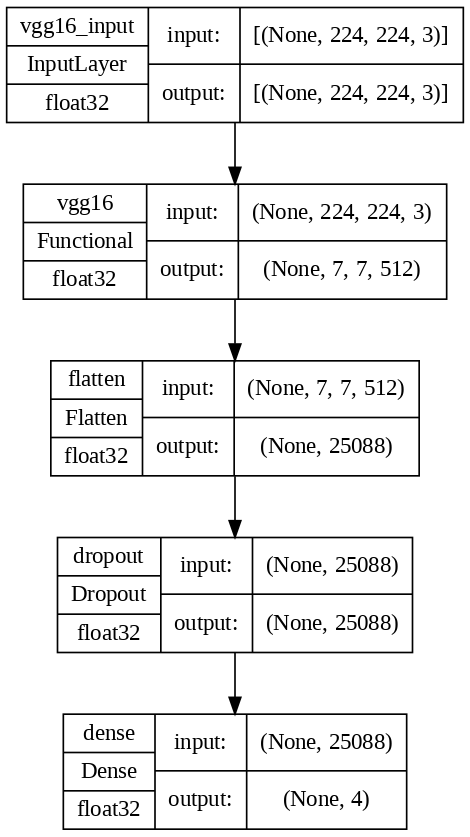

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])
model.save("vgg16_model.h5")

Epoch 1/20
78/78 [==============================] - 328s 4s/step - loss: 4.9452 - accuracy: 0.7945 - val_loss: 1.2295 - val_accuracy: 0.9257
Epoch 2/20
78/78 [==============================] - 13s 166ms/step - loss: 2.7220 - accuracy: 0.8708 - val_loss: 0.9777 - val_accuracy: 0.9418
Epoch 3/20
78/78 [==============================] - 14s 171ms/step - loss: 1.8763 - accuracy: 0.9128 - val_loss: 0.7722 - val_accuracy: 0.9645
Epoch 4/20
78/78 [==============================] - 14s 175ms/step - loss: 1.2287 - accuracy: 0.9411 - val_loss: 0.4187 - val_accuracy: 0.9790
Epoch 5/20
78/78 [==============================] - 14s 170ms/step - loss: 0.9640 - accuracy: 0.9495 - val_loss: 0.8319 - val_accuracy: 0.9548
Epoch 6/20
78/78 [==============================] - 13s 167ms/step - loss: 1.0179 - accuracy: 0.9512 - val_loss: 0.4973 - val_accuracy: 0.9806
Epoch 7/20
78/78 [==============================] - 13s 168ms/step - loss: 1.1072 - accuracy: 0.9495 - val_loss: 0.3444 - val_accuracy: 0.9822
E

In [ ]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

20/20 [==============================] - 3s 125ms/step - loss: 0.3444 - accuracy: 0.9822
Test Loss = 0.34436270594596863
Test Accuracy = 0.9822294116020203


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,4.945246,0.794509,1.229468,0.925687
1,2.721962,0.870811,0.977673,0.941842
2,1.876251,0.912798,0.772211,0.964459
3,1.228749,0.941058,0.418707,0.978998
4,0.964010,0.949536,0.831922,0.954766
5,1.017909,0.951151,0.497299,0.980614
6,1.107194,0.949536,0.344363,0.982229
7,0.888716,0.955995,0.454649,0.964459
8,0.794759,0.965281,0.514467,0.974152
9,0.960004,0.962051,0.885364,0.967690


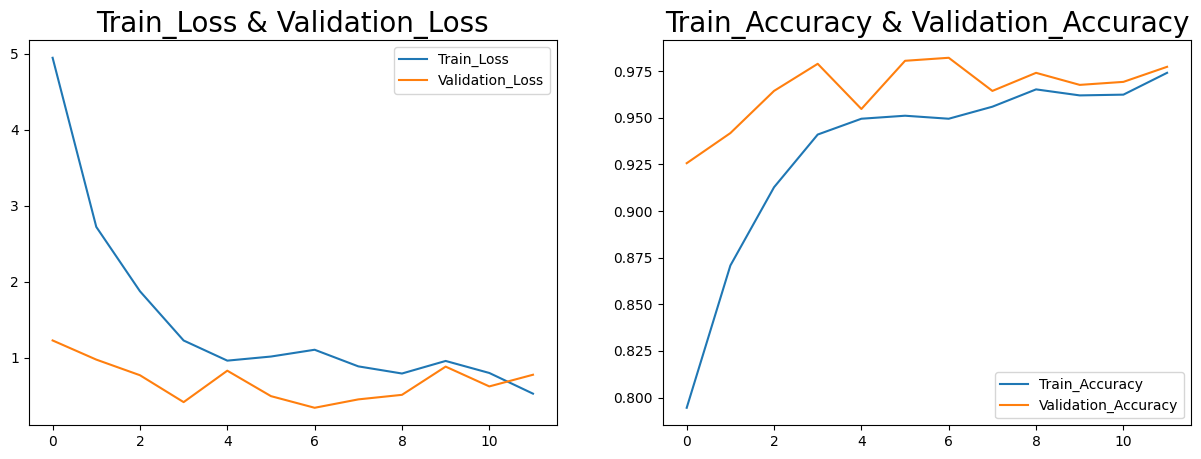

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

20/20 [==============================] - 3s 127ms/step


,Actual,Prediction
0,3,3
1,0,0
2,1,1
3,3,3
4,1,1
...,...,...
614,3,3
615,0,0
616,0,2
617,3,3


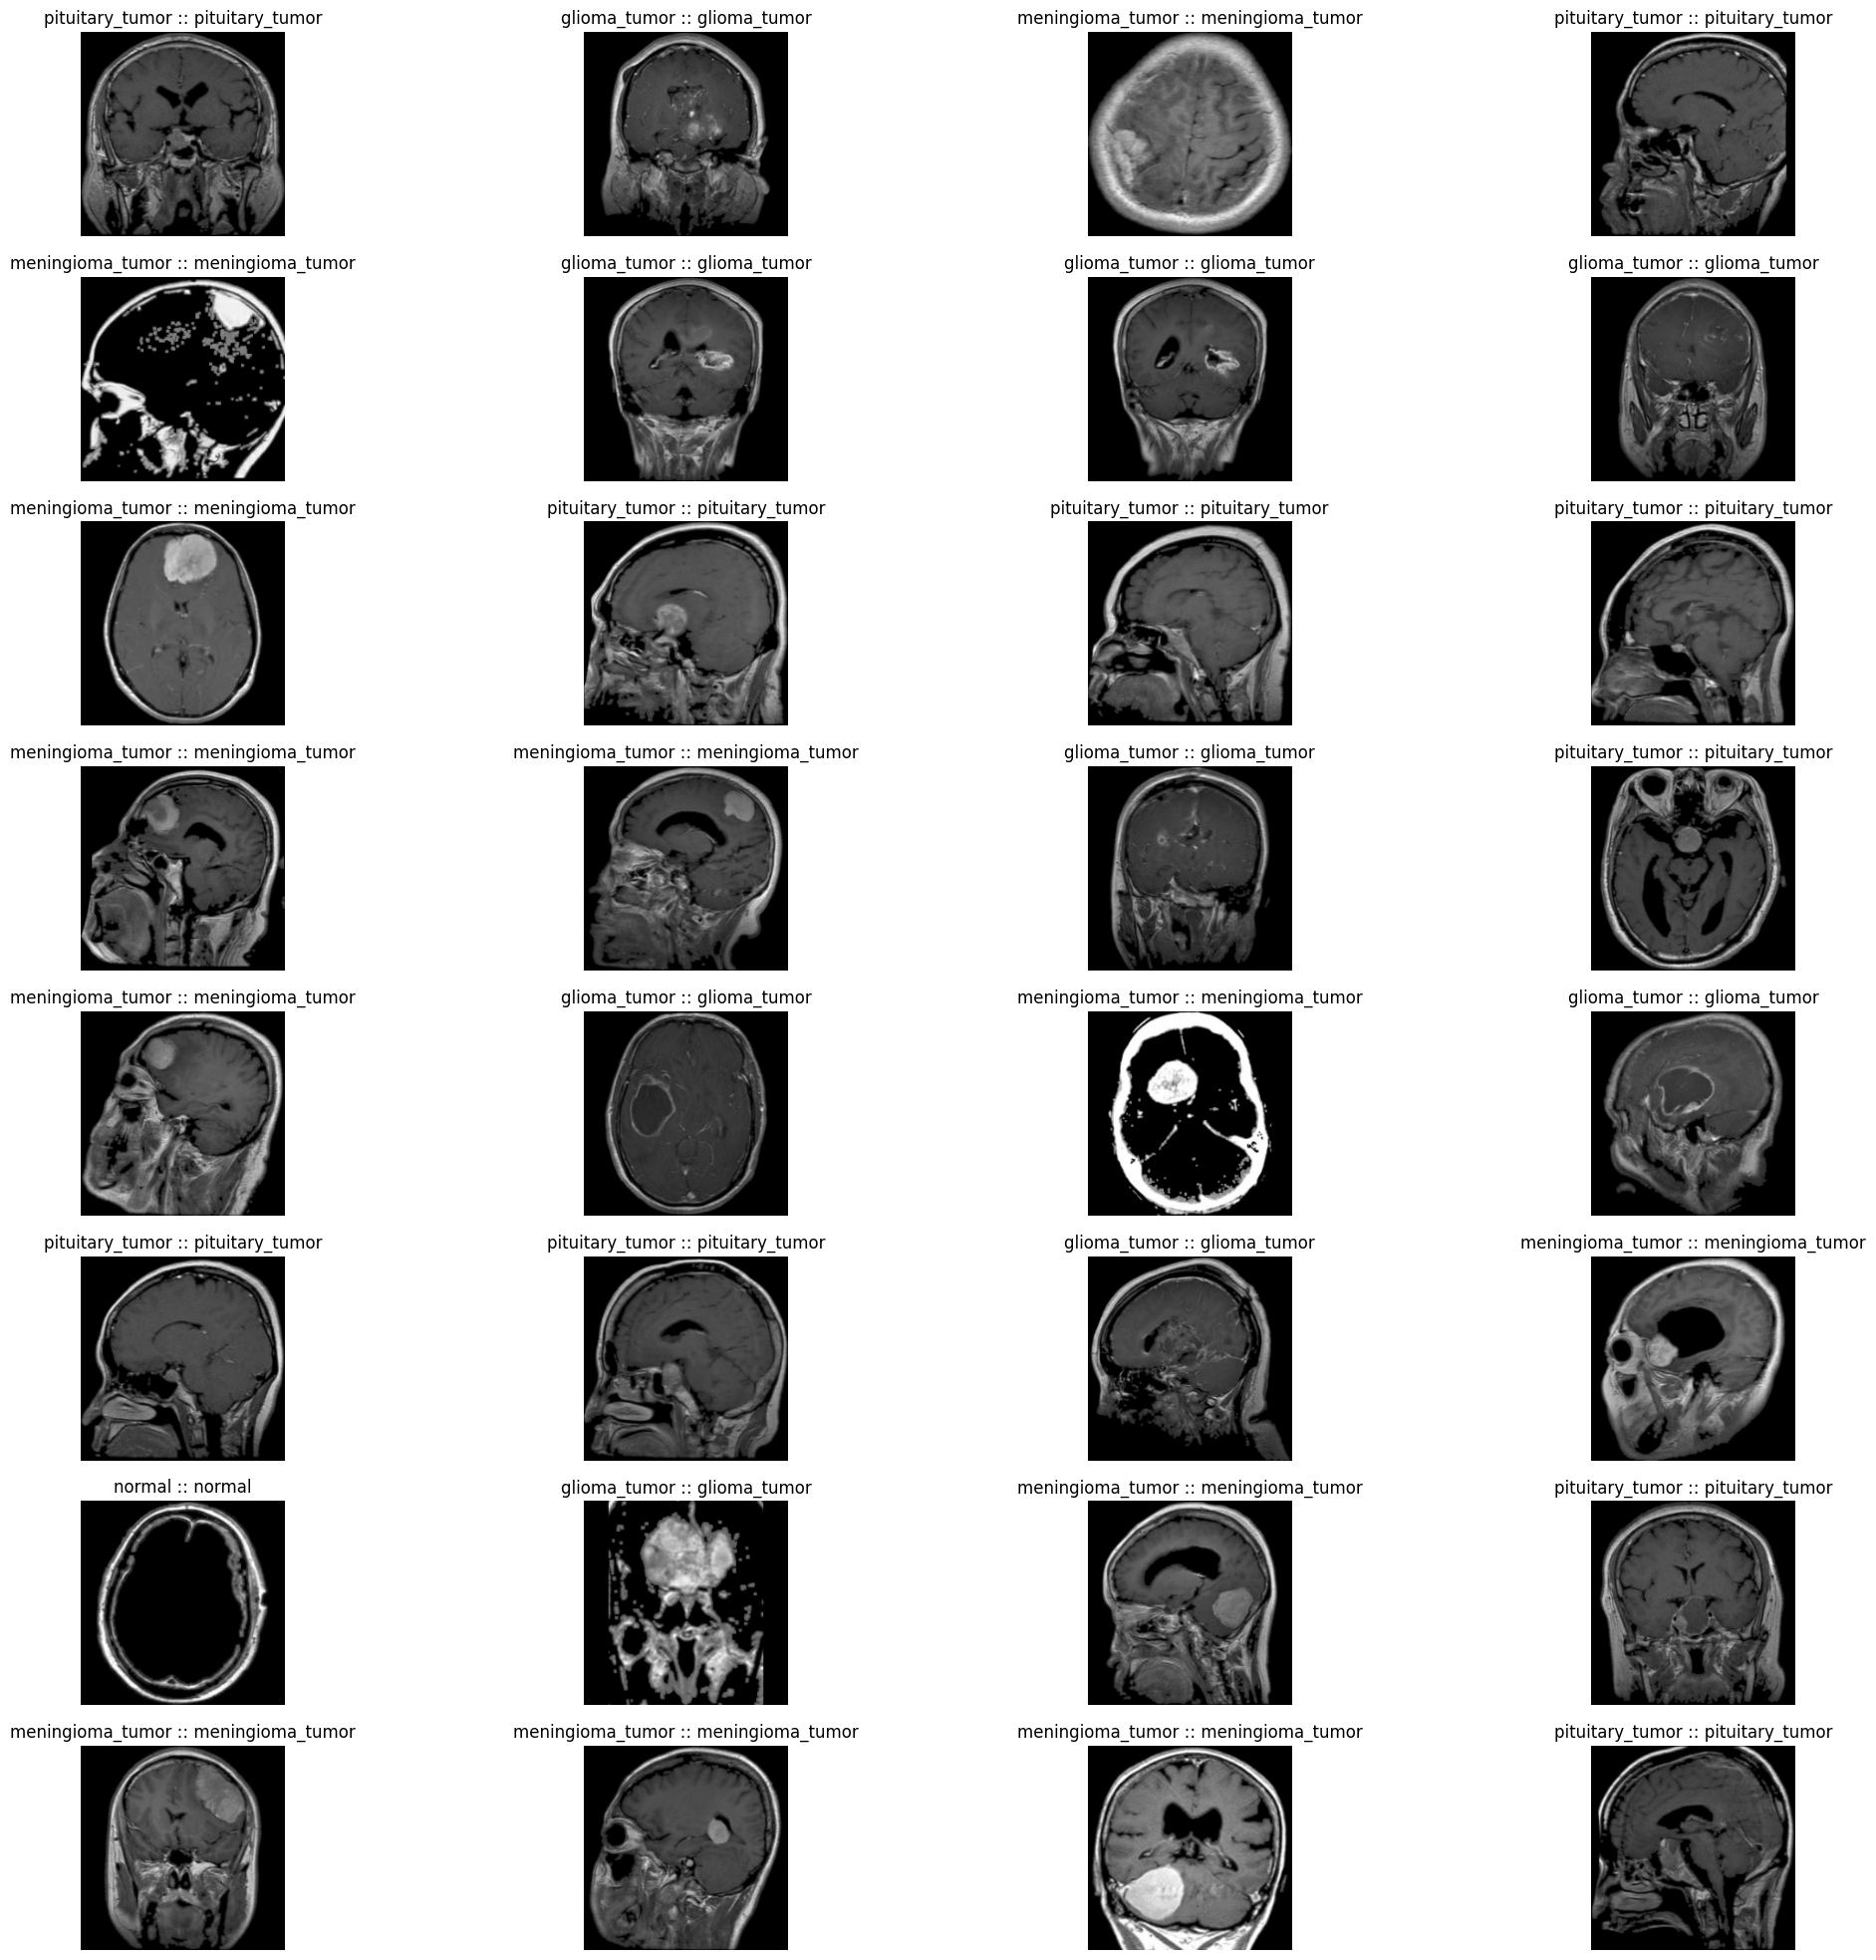

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

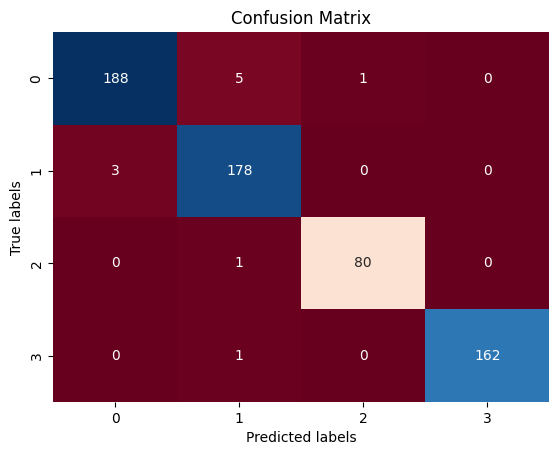

array([[188,   5,   1,   0],
       [  3, 178,   0,   0],
       [  0,   1,  80,   0],
       [  0,   1,   0, 162]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [ ]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.97      0.98       194
           1       0.96      0.98      0.97       181
           2       0.99      0.99      0.99        81
           3       1.00      0.99      1.00       163

    accuracy                           0.98       619
   macro avg       0.98      0.98      0.98       619
weighted avg       0.98      0.98      0.98       619

